# Feature selection
Morphological profile features often exhibit strong correlation structures.
This can obfuscate downstream analysis - such as asking "what features most
often changed between treatment and control? Similarly, features that are
associated with plate map or batch effects can hinder meaningful analysis.
For this reason, `scmorph` integrates ways to remove features that are redundant or associated
with known confounders. 

## Removing correlations

In [1]:
# Ignore warnings
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
import scmorph as sm
import matplotlib.pyplot as plt

adata = sm.datasets.rohban2017_minimal()
adata.shape

(12352, 1687)

This example dataset has 1687 features, many of which will be at least partly
redundant. `scmorph` makes removing redunant features easy:

In [3]:
adata_filtered_pearson = sm.pp.select_features(adata, method="pearson", copy=True)
adata_filtered_pearson.shape

(12352, 1455)

Behind the scenes, this is what happens:
1. Correlate all features with each other
2. For any feature pair with correlation coefficient > threshold (0.9 by
   default), remove one of the features. To decide which one, check which of the
   two features has the higher correlation with all other features.
   
By varying the treshold, we can be more or less stringent in our filtering.

In [4]:
adata_filtered_pearson = sm.pp.select_features(adata, method="pearson", cor_cutoff=0.8, copy=True)
adata_filtered_pearson.shape

(12352, 1306)

Likewise, we can use other correlation coefficients that may be more suitable
for morphological features, which do not always follow normal distributions.

In [5]:
adata_filtered_spearman = sm.pp.select_features(adata, method="spearman", cor_cutoff=0.8, copy=True)
adata_filtered_spearman.shape

(12352, 1295)

We can also subset the data before performing this correlation filtering, which
can help speed up processing speeds for large datasets. For example, if we only
want to use 3000 cells while estimating correlations, we can use `n_obs` as
below. Note that, because we are not using the full data while computing correlation
coefficients, this can influence the number of features retained.

In [6]:
adata_filtered_spearman = sm.pp.select_features(
    adata, method="spearman", cor_cutoff=0.8, copy=True, n_obs=3000
)
adata_filtered_spearman.shape

(12352, 1293)

`scmorph` also integrates an adapted version of the Chatterjee correlation
coefficient, based on [work by Lin and Han (2021)](https://doi.org/10/grdrs2).
While it is slower to compute than the other correlation coefficients, it makes
fewer assumptions and can find correlations that may be missed by
other coefficients of correlation.

In [7]:
adata_filtered_spearman = sm.pp.select_features(
    adata, method="chatterjee", cor_cutoff=0.7, copy=True, n_obs=1000
)
adata_filtered_spearman.shape

(12352, 1477)

Note that `select_features` also does some additional filtering behind the scenes.
Specifically, it removes features with very low variance. Features affected by
this filter are usually not informative and can be safely removed. You can see
which features are affected by this filter after running the `select_features`
function by looking at the corresponding data in `var`:

In [8]:
adata.var["qc_pass_var"].value_counts()

True     1585
False     102
Name: qc_pass_var, dtype: int64

To see some example features that do not pass this variance threshold, you could
use the following:

In [9]:
adata.var.query("qc_pass_var == False").sample(5)

,Object,Module,feature_1,feature_2,feature_3,feature_4,qc_pass_var
Cells_Correlation_Costes_RNA_Mito,Cells,Correlation,Costes,RNA,Mito,NaN,False
Cells_Correlation_Costes_ER_RNA,Cells,Correlation,Costes,ER,RNA,NaN,False
Cytoplasm_Intensity_MeanIntensityEdge_DNA,Cytoplasm,Intensity,MeanIntensityEdge,DNA,NaN,NaN,False
Nuclei_AreaShape_Zernike_9_7,Nuclei,AreaShape,Zernike,9,7,NaN,False
Cells_Intensity_MADIntensity_DNA,Cells,Intensity,MADIntensity,DNA,NaN,NaN,False


## Removing confounded features
In this second part, let's try to remove features that are associated with the
plate ID. Note there is also a dedicated tutorial on [batch
correction](https://scmorph.readthedocs.io/en/latest/tutorials/basics/batch_effects.html),
which covers this topic in more detail. However, the methods discussed here can
also be applied to removing row- or column-effects.

Once again, we will start with the same minimal dataset used above. But now we
will use the Kruskal Wallis statistic to detect features that are associated
with the plate ID.

To find features that may be affected by batch effects, we can run the
`kruskal_test` function.

In [10]:
sm.pp.kruskal_test(adata, test_column="Image_Metadata_Plate")

  0%|          | 0/1687 [00:00<?, ?it/s]

AnnData object with n_obs × n_vars = 12352 × 1687
    obs: 'TableNumber', 'ImageNumber', 'ObjectNumber', 'Image_Metadata_Plate', 'Image_Metadata_Site', 'Image_Metadata_Well', 'PUBLICID', 'TA_GeneID', 'Duplicate.ORFs', 'TARGETTRANS', 'Activator.Inhibitor', 'CONSTRUCTNAME', 'ISMUTANT', 'TARGETGENE', 'TA_REF.vs..DLBCL', 'ReferencePathway.Process'
    var: 'Object', 'Module', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'qc_pass_var'
    uns: 'kruskal_test'
    obsm: 'inter_cell_features', 'intra_cell_features'
    varm: 'pearson', 'spearman', 'chatterjee'

This function stores information about features' association in the `uns` slot:

In [11]:
adata.uns["kruskal_test"]["Image_Metadata_Plate"].sort_values("statistic", ascending=False).head()

,feature,statistic,pvalue
834,Cytoplasm_Intensity_MinIntensityEdge_Mito,5839.897372,0.0
1387,Cells_Intensity_MinIntensityEdge_Mito,5839.507005,0.0
839,Cytoplasm_Intensity_MinIntensity_Mito,5750.462632,0.0
1392,Cells_Intensity_MinIntensity_Mito,5750.453496,0.0
93,Nuclei_Correlation_K_RNA_Mito,4280.823174,0.0


Oftentimes the p-value obtained from the KW test is overly harsh - most features
are marked as significantly associated with plate IDs, while the KW statistics
are mostly not as extreme as the p-value would suggest.

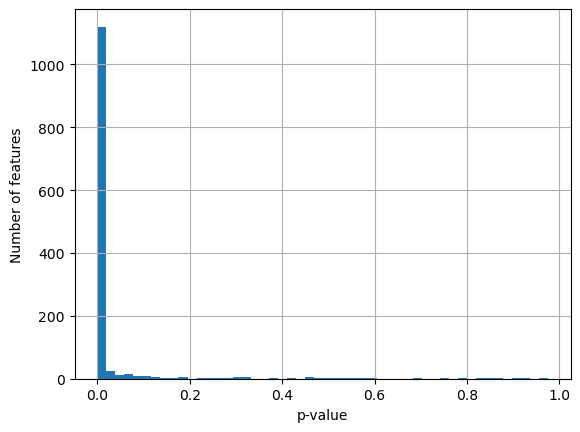

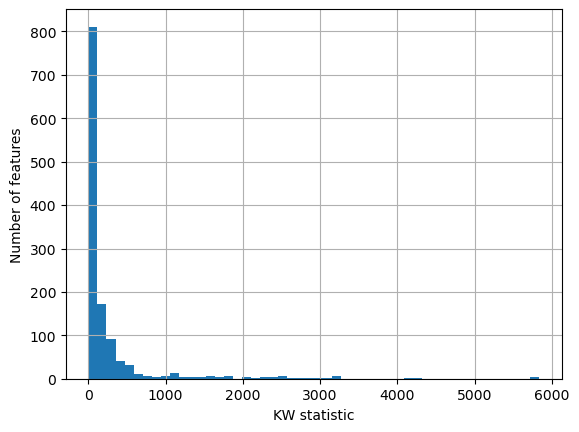

In [12]:
adata.uns["kruskal_test"]["Image_Metadata_Plate"]["pvalue"].hist(bins=50)
plt.xlabel("p-value")
plt.ylabel("Number of features")
plt.show()

adata.uns["kruskal_test"]["Image_Metadata_Plate"]["statistic"].hist(bins=50)
plt.xlabel("KW statistic")
plt.ylabel("Number of features")
plt.show()

So we can instead choose to filter features based on how extreme their KW
statistic is. To do so, we can use the `kruskal_filter` function which marks a
feature as associated with batches if its KW statistic is more than one median
absolute deviation away from the median of all other features' KW statistics.
Applying this here, this removes about half of the features as associated with
plate IDs.

In [13]:
adata.shape

(12352, 1687)

In [14]:
adata_filtered = sm.pp.kruskal_filter(adata, "Image_Metadata_Plate", copy=True)
adata_filtered.shape

(12352, 796)

You could think of applying the same principle to row or column IDs to remove
features associated with plate map effects.

Taken together, with `scmorph` you can mitigate some of the problems that
morphological profiling experiments hold - such as batch effects and heavy
correlation structures.